### Prototyping the Analysis Pipeline for the Oberisk


LogisticRegression Performance:
Accuracy: 0.9882
Precision: 0.9842
Recall: 1.0000
F1 Score: 0.9920

RandomForest Performance:
Accuracy: 0.9693
Precision: 0.9901
Recall: 0.9678
F1 Score: 0.9789

XGBoost Performance:
Accuracy: 0.9905
Precision: 0.9968
Recall: 0.9904
F1 Score: 0.9935


e:\6 KI\8_ML413N Project management and tools for health informatics\PROHI-dashboard-Oberisk\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LightGBM Performance:
Accuracy: 0.9882
Precision: 0.9935
Recall: 0.9904
F1 Score: 0.9919

Model Performance Comparison:
                    Accuracy  Precision    Recall  F1 Score
LogisticRegression  0.988180   0.984177  1.000000  0.992026
RandomForest        0.969267   0.990132  0.967846  0.978862
XGBoost             0.990544   0.996764  0.990354  0.993548
LightGBM            0.988180   0.993548  0.990354  0.991948

Best model: XGBoost
Final model trained on all data
Model saved as ./models/obesity_risk_model.pkl

Top 10 Feature Importances:
1. weight: 0.4656
2. height: 0.1156
3. freq_snack_Sometimes: 0.0899
4. transport_Walking: 0.0600
5. freq_snack_Frequently: 0.0460
6. sex_Female: 0.0358
7. age: 0.0251
8. water_daily: 0.0250
9. family_history_no: 0.0232
10. transport_Automobile: 0.0224


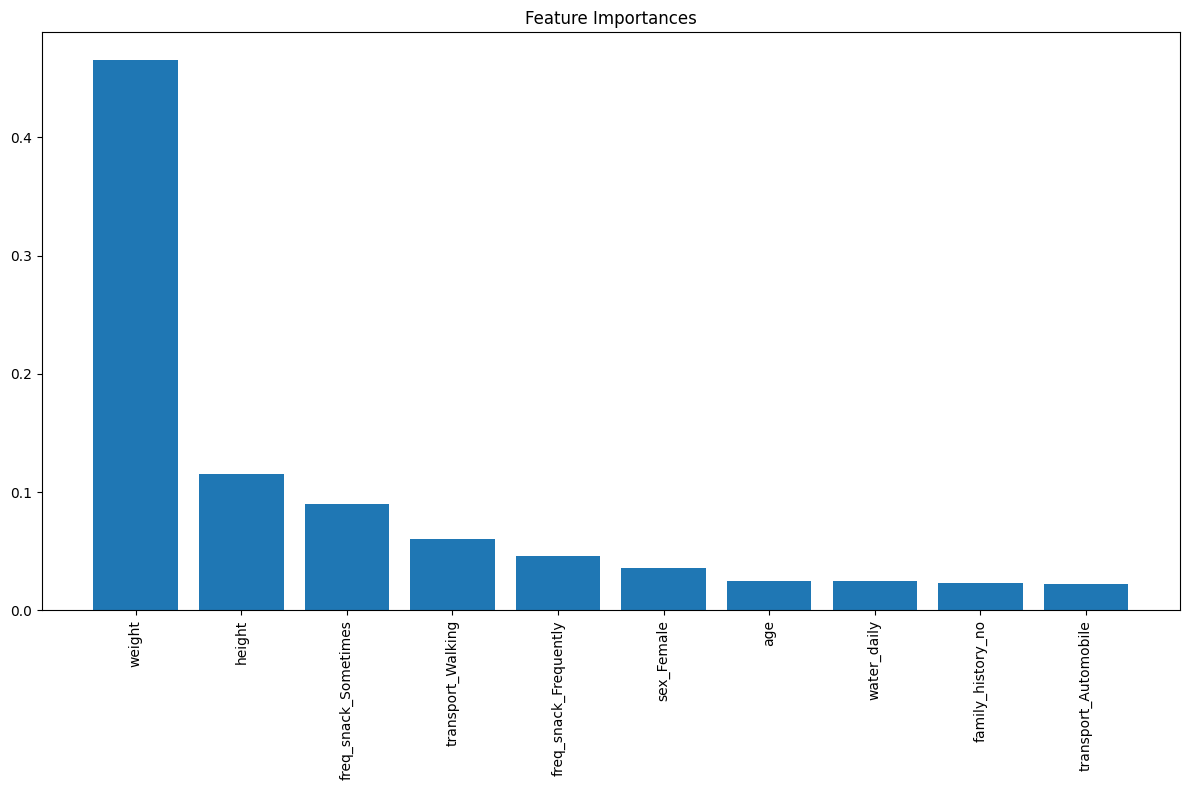

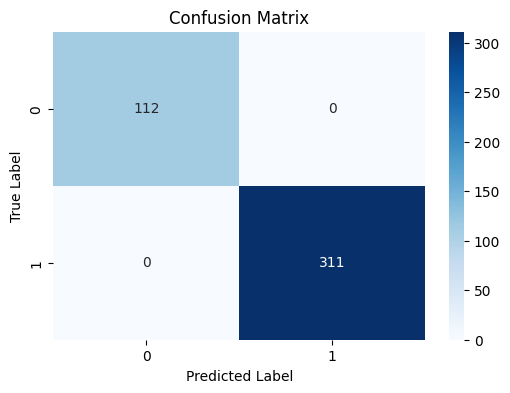

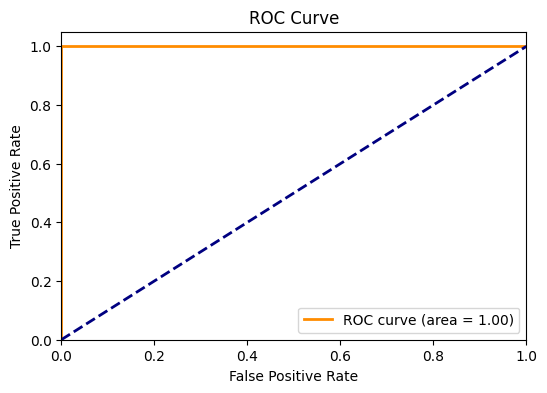

Analysis complete! Model and visualizations saved.


In [1]:
# Data Pipeline for Obesity Risk Prediction

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import xgboost as xgb
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv('../assets/ObesityDataSet_raw_and_data_sinthetic.csv')
data.columns = data.columns.str.strip()

# Rename columns
data = data.rename(columns={
    "Age": "age",
    "Gender": "sex",
    "Weight": "weight",
    "Height": "height",
    "family_history_with_overweight": "family_history",
    "FAVC": "often_high_calorie_intake",
    "FCVC": "veggie_per_meal",
    "NCP": "meals_daily",
    "CAEC": "freq_snack",
    "SMOKE": "smoking",
    "CH2O": "water_daily",
    "SCC": "monitor_calorie",
    "FAF": "physical_activity",
    "TUE": "technological_devices",
    "CALC": "freq_alcohol",
    "MTRANS": "transport",
    "NObeyesdad": "bmi_category"
})

# Convert multi-class target to binary
data["obesity_risk"] = data["bmi_category"].apply(
    lambda x: 0 if x in ['Insufficient_Weight', 'Normal_Weight'] else 1
)

# Define features and target
target = "obesity_risk"
X = data.drop(columns=[target, "bmi_category"])
y = data[target]

# Identify numeric and categorical variables
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss", random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("clf", model)
    ])
    
    # Train model
    pipe.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipe.predict(X_test)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }
    
    print(f"\n{name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Model comparison
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)

# Find best model
best_model_name = results_df['Accuracy'].idxmax()
print(f"\nBest model: {best_model_name}")

# Train final model on all data
final_model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", models[best_model_name])
])

final_model.fit(X, y)
print("Final model trained on all data")

# Save the model
import os
os.makedirs("./models", exist_ok=True)
joblib.dump(final_model, "./models/obesity_risk_model.pkl")
print("Model saved as ./models/obesity_risk_model.pkl")

# Feature importance (for tree-based models)
if hasattr(models[best_model_name], 'feature_importances_'):
    # Get feature names
    preprocessor.fit(X)
    feature_names = (numeric_cols + 
                     list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)))
    
    # Get feature importances
    importances = models[best_model_name].feature_importances_
    indices = np.argsort(importances)[::-1]
    
    print("\nTop 10 Feature Importances:")
    for i in range(10):
        print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances")
    plt.bar(range(10), importances[indices[:10]])
    plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=90)
    plt.tight_layout()
    plt.savefig("./models/feature_importances.png")
    plt.show()

# Confusion matrix and ROC curve for the best model
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig("./models/confusion_matrix.png")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("./models/roc_curve.png")
plt.show()

print("Analysis complete! Model and visualizations saved.")